# Replicate focus- and single-cell gate from IDEAS using the SCI feature extraction tool

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import umap
import sqlite3
from ehv import core

In [32]:
db_file = "data/sc_gate_allCtrl.sqlite3"

In [2]:
db_file = "/data/dev/active/sci-java-mvn/output.sqlite3"

In [3]:
df = core.load_from_sqlite_db(db_file)

In [4]:
df["feat_haralickContrast_0"] = df.filter(regex="feat_haralickContrast.*_0").mean(axis=1)

In [5]:
df.head()

,feat_min_0,feat_mad_0,feat_median_0,feat_haralickContrastDIAGONAL_0,feat_mainElongation_0,meta_file,feat_haralickEntropyDIAGONAL_0,feat_minorAxis_0,feat_convexity_0,feat_haralickEntropyHORIZONTAL_0,...,feat_haralickCorrelationVERTICAL_0,feat_sizeConvexHull_0,feat_max_0,feat_stdDev_0,feat_haralickContrastHORIZONTAL_0,feat_sizeMask_0,meta_replicate,meta_timepoint,meta_fiji,feat_haralickContrast_0
0,739,24.285000,783.0,373.226277,0.329154,C1_T0_49.cif,4.814972,16.314806,0.811439,5.056142,...,-0.169685,316.0,927,36.857597,280.453125,1804,C1,0,21,324.258793
1,744,28.437378,782.5,381.257576,0.058824,C1_T0_49.cif,4.748847,16.771626,0.976840,4.877050,...,-0.215051,234.5,971,44.749978,333.355422,1836,C1,0,7,354.159403
2,316,53.913136,802.0,301.722628,0.000000,C1_T0_49.cif,4.510065,16.912225,0.968748,4.464428,...,-0.189063,240.0,848,91.340801,247.093567,2464,C1,0,11,275.079049
3,583,35.436968,800.0,329.285714,0.127273,C1_T0_49.cif,5.282048,20.820410,0.934956,5.290927,...,0.011563,425.0,850,50.458152,150.273885,2025,C1,0,1,235.334889
4,751,24.860696,780.0,266.765957,0.000000,C1_T0_49.cif,5.045827,21.189179,0.974330,4.953206,...,0.111336,367.5,988,39.708445,195.641844,2132,C1,0,25,221.512787


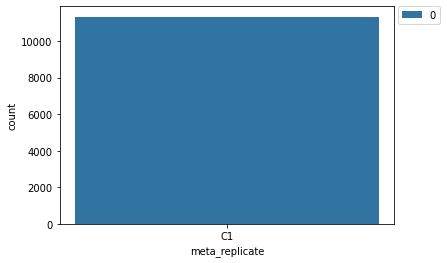

In [6]:
seaborn.countplot(data=df, x="meta_replicate", hue="meta_timepoint", hue_order=sorted(df["meta_timepoint"].unique())).legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

Cell counts per file vary widely. This could pose a problem if we expect changes to occur in the control samples as time progresses.

Next, we plot size in function of roundness. A good gate for selecting images containing single cells.

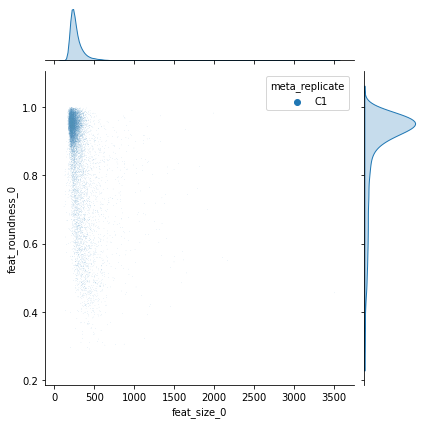

In [7]:
seaborn.jointplot(data=df, x="feat_size_0", y="feat_roundness_0", hue="meta_replicate", s=0.1)

In [8]:
df["feat_size_0"].describe()

count    11327.000000
mean       286.199479
std        136.090735
min        121.500000
25%        218.000000
50%        248.000000
75%        303.000000
max       3510.500000
Name: feat_size_0, dtype: float64

We want to filter out very small datapoints, regardless of their roundness. 50 seems a good cut-off from inspecting the dataset.

For the roundness we want to select cells in [0.8 - 1.0].

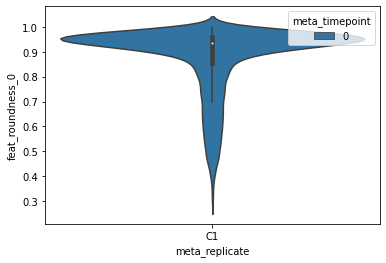

In [9]:
seaborn.violinplot(data=df, x="meta_replicate", y="feat_roundness_0", hue="meta_timepoint")

In [10]:
roundness_stats = df.groupby(["meta_timepoint", "meta_replicate"])["feat_roundness_0"].agg(["mean", "std"])
roundness_lower_bound = roundness_stats["mean"] - 2*roundness_stats["std"]

In [11]:
df_gate1 = df[
    (df["feat_roundness_0"] > 0.8) &
    (df["feat_size_0"] > 50)
]

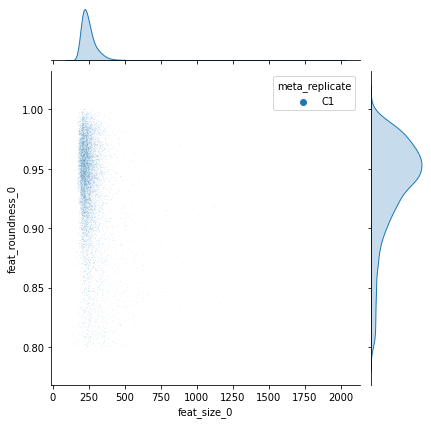

In [12]:
seaborn.jointplot(data=df_gate1, x="feat_size_0", y="feat_roundness_0", hue="meta_replicate", s=0.1)

In [13]:
df.shape

(11327, 45)

In [14]:
df_gate1.shape

(9087, 45)

In [15]:
from importlib import reload
reload(core)

<module 'ehv.core' from '/data/dev/active/EhV-analysis/ehv/core.py'>

In [16]:
core.add_gating_table(db_file)

In [17]:
core.add_gate(db_file, "gate1", df_gate1)

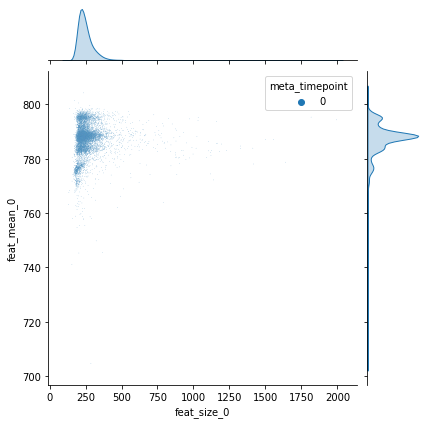

In [18]:
grid = seaborn.jointplot(data=df_gate1, x="feat_size_0", y="feat_mean_0", s=0.2, hue="meta_timepoint")


In [15]:
df_gate2 = df[(df["feat_size_0"] > 150) & (df["feat_size_0"] < 400) & (df["feat_roundness_0"] > 0.85)]

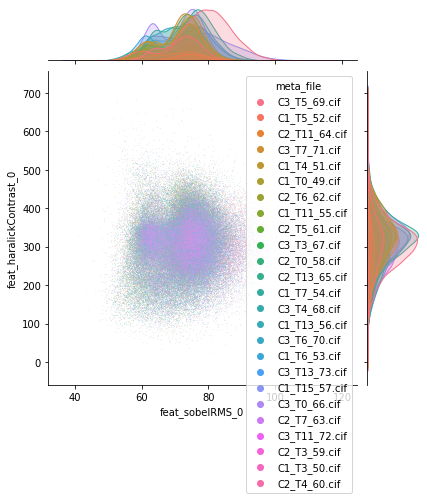

In [16]:
seaborn.jointplot(data=df_gate2, x="feat_sobelRMS_0", y="feat_haralickContrast_0", hue="meta_file", s=0.2)

In [74]:
df_gate2[df_gate2["feat_sobelRMS_0"] < 65].filter(regex="meta")

,meta_file,meta_directory,meta_id,meta_fiji
12,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,22,45
17,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,21,43
18,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,20,41
26,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,27,55
33,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,40,81
...,...,...,...,...
39887,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19886,39773
39889,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19889,39779
39917,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19915,39831
39935,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19929,39859


In [75]:
df_gate2[df_gate2["feat_sobelRMS_0"] > 80].filter(regex="meta")

,meta_file,meta_directory,meta_id,meta_fiji
0,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,16,33
4,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,7,15
40,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,45,91
85,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,87,175
86,C3_T0_66.cif,/home/maximl/personal/data/Ctrl/C3_T0_66.cif,91,183
...,...,...,...,...
39916,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19917,39835
39944,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19944,39889
39954,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19953,39907
39965,C2_T0_58.cif,/home/maximl/personal/data/Ctrl/C2_T0_58.cif,19965,39931


# Comparing gradient and texture features

Gradient features are used to detect images with high contrast and texture. Current texture related features in the feature set are:
- haralickContrast
- haralickCorrelation
- haralickEntropy
- tamuraContrast
- sobelRMS
- gradientRMS

In [12]:
df = pandas.read_csv("data/output-texture.csv")

In [16]:
df["feat_haralickContrast_0"] = df.filter(regex="feat_haralickContrast.*_0").mean(axis=1)
df["feat_haralickEntropy_0"] = df.filter(regex="feat_haralickEntropy.*_0").mean(axis=1)
df["feat_haralickCorrelation_0"] = df.filter(regex="feat_haralickCorrelation.*_0").mean(axis=1)

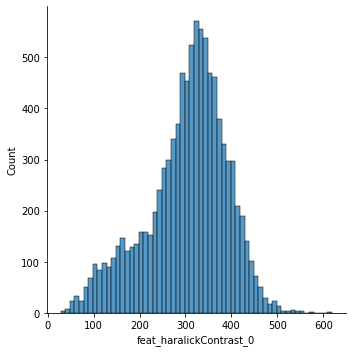

In [17]:
seaborn.displot(df["feat_haralickContrast_0"])

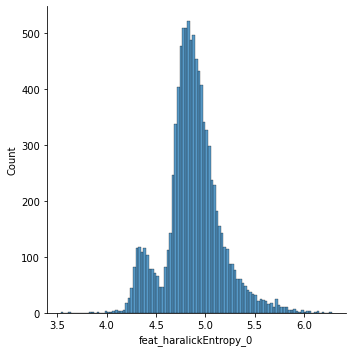

In [18]:
seaborn.displot(df["feat_haralickEntropy_0"])

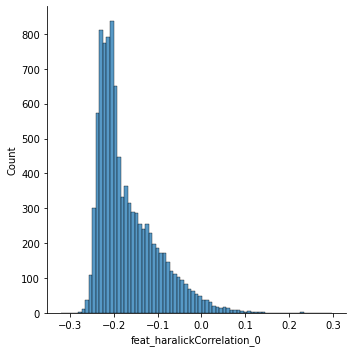

In [20]:
seaborn.displot(df["feat_haralickCorrelation_0"])

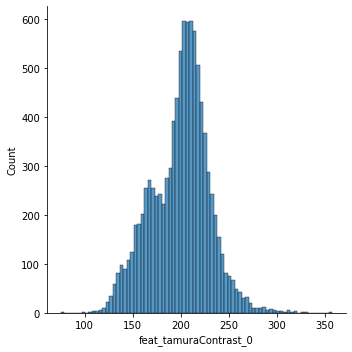

In [21]:
seaborn.displot(df["feat_tamuraContrast_0"])

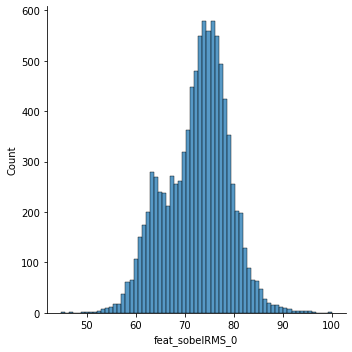

In [22]:
seaborn.displot(df["feat_sobelRMS_0"])

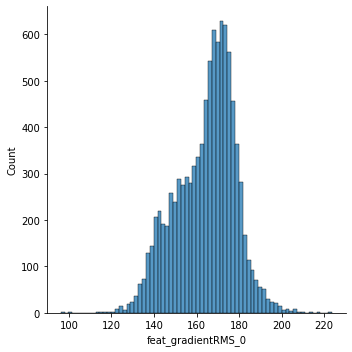

In [24]:
seaborn.displot(df["feat_gradientRMS_0"])

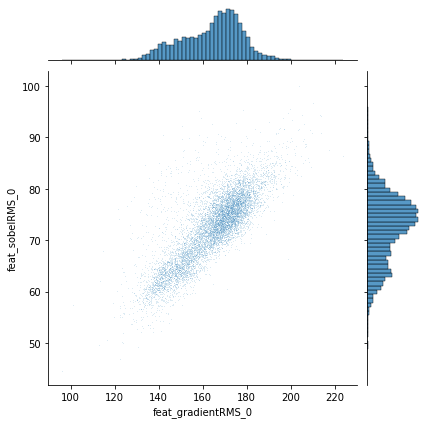

In [26]:
seaborn.jointplot(data=df, x="feat_gradientRMS_0", y="feat_sobelRMS_0", s=0.2)

## Comparing gradientRMS with different kernel sizes

In [27]:
df = pandas.read_csv("data/output-gradient.csv")

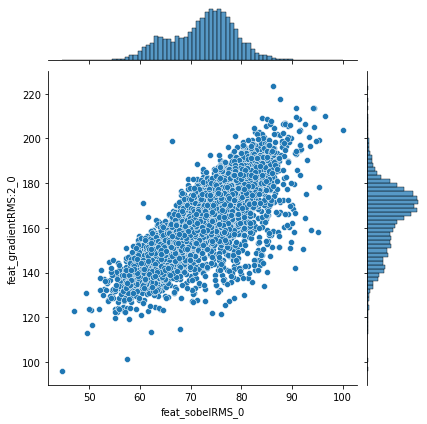

In [36]:
seaborn.jointplot(data=df, x="feat_sobelRMS_0", y="feat_gradientRMS:2_0")